In [1]:
import pandas as pd
import ternary
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('talk')

from borfr import BO_RFR, fps
import warnings
warnings.filterwarnings("ignore")
from synth_data.plotting_helpers_mixture_frederic import plot_mixture_4d



df = pd.read_csv('data_cond/calisol23_DOI_10.11583DTU.c.6929599.csv',sep=',')
inds1 = np.where(df['c units'].values == 'mol/kg')[0]
inds2 = np.where(df['solvent ratio type'].values == 'w')[0]
inds = np.array(list(set(inds1).intersection(set(inds2))))
#inds = np.arange(df.values.shape[0])

inds2 = np.where(df['k'].values <= 39.)[0]
inds = np.array(list(set(inds).intersection(set(inds2))))

inds2 = np.where(np.isfinite(df['k'].values) == True)[0]
inds = np.array(list(set(inds).intersection(set(inds2))))

#inds2 = np.where(df['solvent ratio type'].values == 'w')[0]
#inds = np.array(list(set(inds).intersection(set(inds2))))

conds = df['k'].values[inds]
cols = ['T', 'c', 'salt', 'EC', 'PC', 'DMC', 'EMC', 'DEC', 'DME', 'TFP', 'EA', 'MA', 'FEC',]



In [2]:
salt = np.zeros(inds.shape)
salts = np.unique(df['salt'].values[inds])
for ii,i in enumerate(salts):
    salt[df['salt'].values[inds]==i] = ii
df = pd.DataFrame(df[cols].values[inds], columns=cols)
df['salt'] = salt



<Axes: ylabel='Density'>

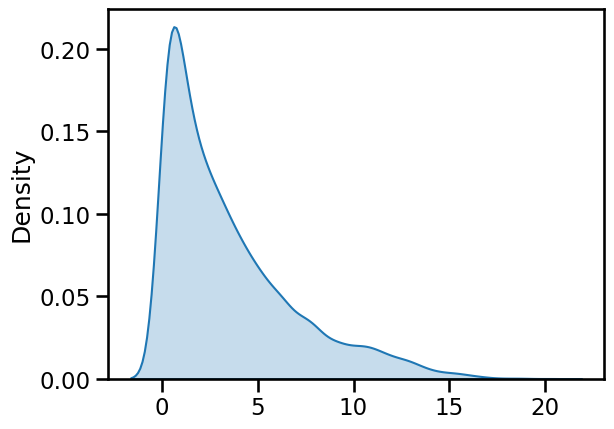

In [3]:
fig,ax = plt.subplots()
sns.kdeplot(conds, gridsize=200, fill=True)

In [4]:
def f(x):
    ind = np.argmin(np.linalg.norm(grid-x, axis=1))
    return vals[ind]

def get_label(x):
    ind = np.argmin(np.linalg.norm(grid-x, axis=1))
    return ref_labels[ind]


grid = np.array(df.values, dtype=float)
vals = conds

ref_labels = np.zeros(conds.shape)
ref_labels[conds > 10.] = 1.


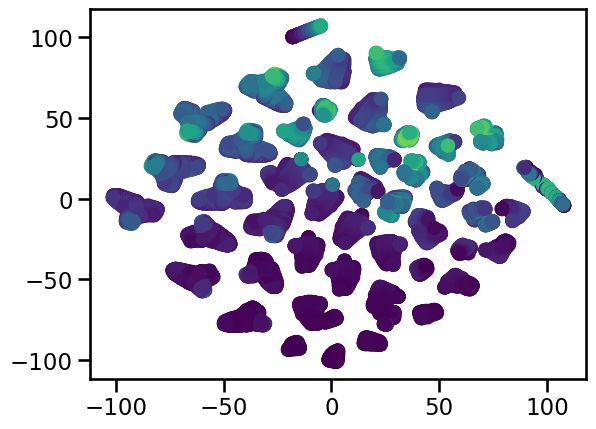

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(grid)

fig,ax = plt.subplots()
ax.scatter(*tsne.T, c=vals)

In [10]:
np.random.seed(5)

X_init = fps(grid,20)
#X_init = grid[np.random.randint(0,171,4)]
y_init = np.array([f(xi) for xi in X_init])

x_test = grid

regm = 'RFC'
clm = 'RFC'

esl = 'AC'

n_iter = 200
nb = 10
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=.3, 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=True)

bor.run(n_iter_b)

rand_scores = []
for i in range(30):
    rand = BO_RFR(X_init, y_init, grid, f, x_test, 
                  acq='random',gl = get_label,  
                  est_labels=esl, N_batch=1,
                  class_method = clm, reg_method = regm)
    
    rand.run(n_iter)
    rand_scores.append(rand.scores)


sf = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm)

sf.run(n_iter)

gp = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm, gpr=True)

gp.run(n_iter)

generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 12090.81it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.13it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11049.80it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.63it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10184.77it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.64it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10744.77it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.64it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11007.28it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.58it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10705.20it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.59it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11309.03it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.55it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10983.61it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:21<00:00,  2.45it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10883.35it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.55it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11177.06it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.53it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10980.39it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.53it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10820.17it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.60it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11117.17it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.56it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11132.89it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.54it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10325.35it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.42it/s]


generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 9751.15it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:25<00:00,  2.34it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10326.13it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:24<00:00,  2.37it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10716.76it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:23<00:00,  2.40it/s]


generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 9950.18it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.57it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11448.25it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.61it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11012.26it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11567.13it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11611.51it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10613.85it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10743.30it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.67it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11481.97it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.69it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11340.20it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.68it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10816.86it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.70it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10542.31it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.68it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10574.48it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:14<00:00,  2.68it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 10105.03it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:17<00:00,  2.59it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11342.03it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.61it/s]


generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11768.88it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.06it/s]


In [35]:
regm = 'RFC'
clm = 'RFC'

esl = 'known'

n_iter = 200
nb = 5
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=1., 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=True)

bor.run(n_iter_b)

generating test data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9725/9725 [00:00<00:00, 11958.72it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.27it/s]


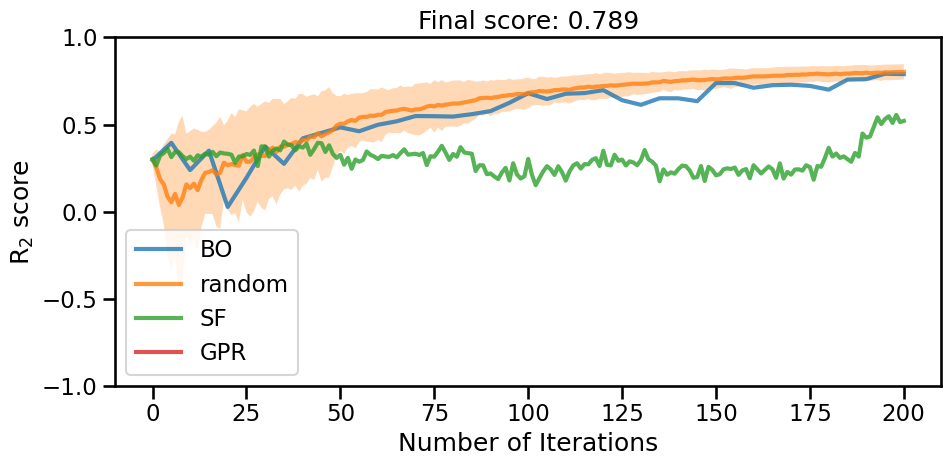

In [36]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                     np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),gp.scores,lw=3,alpha=0.8, label='GPR')
except:
    pass
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$_2$ score')
ax2.set_ylim(-1,1)
ax2.legend()
plt.tight_layout()

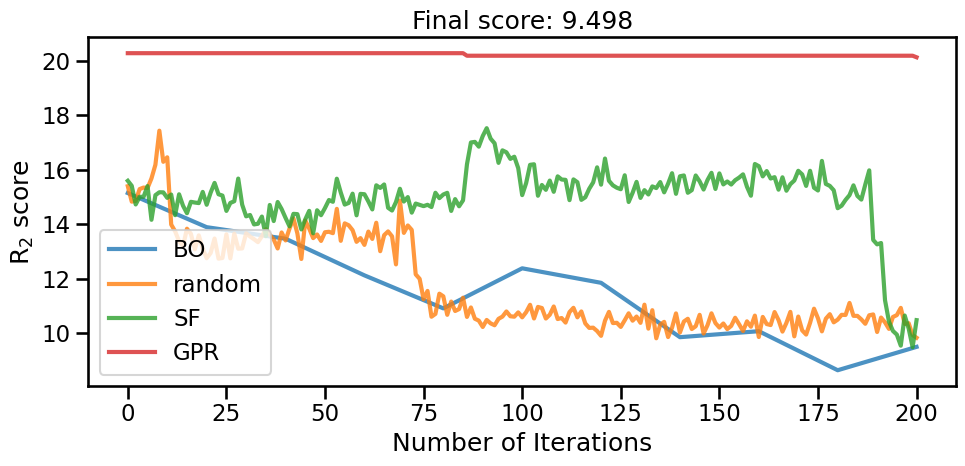

In [32]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

si = 3

ax2.plot(np.arange(bor.n_iters+1)*nb,np.array(bor.all_scores)[:,si],lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.array(rand.all_scores)[:,si],lw=3,alpha=0.8, label='random')
    #ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
    #                 np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),np.array(sf.all_scores)[:,si],lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),np.array(gp.all_scores)[:,si],lw=3,alpha=0.8, label='GPR')
except:
    pass
ax2.set_title('Final score: %.3f'%np.array(bor.all_scores)[:,si][-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$_2$ score')
#ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()

(array([2.21009654e-01, 1.10962720e-01, 6.72593836e-02, 4.12612406e-02,
        2.24876305e-02, 1.80104552e-02, 9.00522761e-03, 2.23858765e-03,
        7.12277890e-04, 2.03507969e-04]),
 array([ 0.        ,  2.02777778,  4.05555556,  6.08333333,  8.11111111,
        10.13888889, 12.16666667, 14.19444445, 16.22222222, 18.25      ,
        20.27777778]),
 <BarContainer object of 10 artists>)

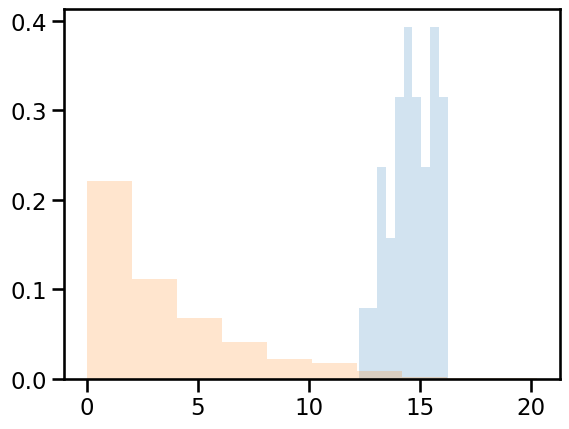

In [14]:
blabs = bor.classifier.predict(grid)
fig,ax = plt.subplots()
ax.hist(vals[blabs==0],alpha=0.2, density=True)
ax.hist(vals[blabs==1],alpha=0.2, density=True)

0.9935777915889786

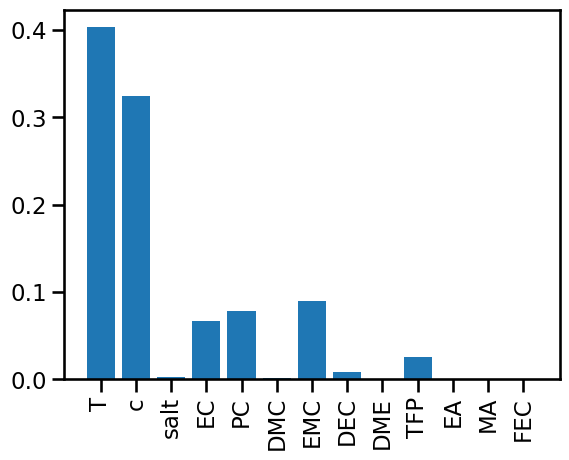

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler

X = StandardScaler().fit_transform(grid)

lda = LDA().fit(X, blabs)


fig,ax=plt.subplots()
ax.bar(range(len(cols)), bor.classifier.feature_importances_)
ax.set_xticks(range(len(cols)), labels=cols, rotation=90)

f1_score(blabs, lda.predict(X))

generating test data


100%|████████████████████████████████████| 9725/9725 [00:00<00:00, 12196.05it/s]


running iterative exploration:


100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.49it/s]


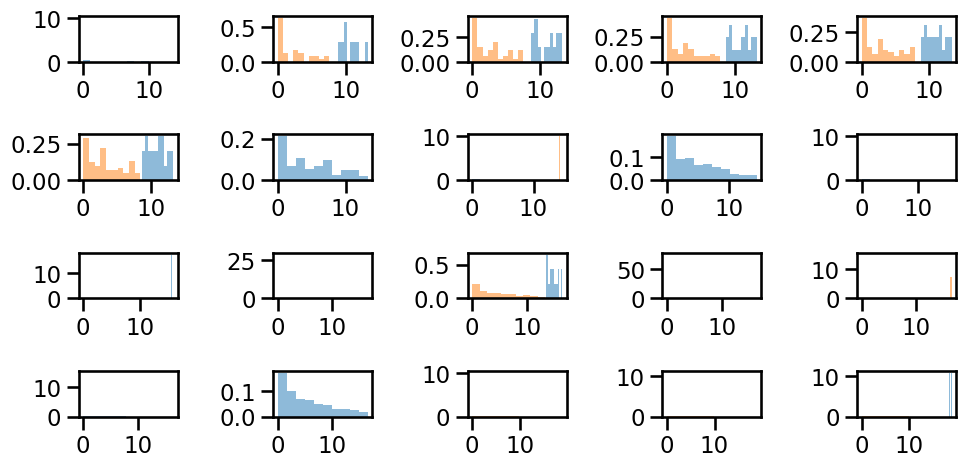

In [29]:
n_iter = 400
nb = 20
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=.3, 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=False)

bor.run(n_iter_b)


Ni = len(bor.Xs)

fig,axes = plt.subplots(ncols=int(Ni/4),nrows=4, figsize=(10,5))
axes = axes.ravel()
for i in range(Ni-1):
    dat = bor.cl_models[i].predict(bor.Xs[i])
    axes[i].hist(bor.ys[i][dat==0],alpha=0.5, density=True)
    axes[i].hist(bor.ys[i][dat==1],alpha=0.5, density=True)
plt.tight_layout()

In [ ]:
rats1 = grid[blabs==0][:,-2]
rats1 = rats1[np.isfinite(rats1)]

rats2 = grid[blabs==1][:,-2]
rats2 = rats2[np.isfinite(rats2)]
fig,ax = plt.subplots()
ax.hist(rats1,alpha=0.4,density=True)
ax.hist(rats2,alpha=0.4,density=True)

In [241]:
X[:,3].max()

1.0